## Libraries and Helper Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired,MaximalMarginalRelevance
from bertopic.representation import OpenAI as OpenAI_BERTopic
from sentence_transformers import SentenceTransformer

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import os
from dotenv import load_dotenv

import optuna

nltk.download('punkt')
nltk.download('stopwords')

import torch
import random
import os

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
load_dotenv(override=True)

True

In [3]:
import openai
from openai import OpenAI
import json

openai.api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

def summarize_topic(keywords, docs):
    prompt = f"Saya mempunyai sebuah topik terkait literatur ilmiah terkait riset dan inovasi kecerdasan buatan yang dapat di-deskripsikan dengan beberapa kata kunci berikut: {keywords}\n\n"
    prompt += "Di dialam topik ini, dokumen-dokumen berikut yang merupakan abstrak dari literatur ilmiah merupakan sebagian kecil namun representatif dari semua dokumen dalam topik ini:\n\n"
    prompt += "\n\n".join(docs[:5])  # ambil 5 dokumen saja
    prompt += 'Berdasarkan informasi di atas, deskripsikan topik ini dan berikan label berupa satu kaliamat yang representatif terhadap topik ini dengan format JSON berikut:\n {"label_topik":<label> , "deskripsi":<deskripsi>}'
    response = client.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=[
            {"role": "system", "content": 'Kamu adalah asisten akademik yang merangkum topik. Anda adalah model yang hanya menjawab dalam format JSON valid. Jangan beri penjelasan. Berikan hanya output seperti ini: {"label_topik": "...", "deskripsi": "..."}'},
            {"role": "user", "content": prompt}
        ],
        temperature=0.5,
        max_tokens=300
    )
    content = response.choices[0].message.content.strip()
    try:
        match = re.search(r'\{.*?\}', content, re.DOTALL)
        json_str = match.group(0)
        result = json.loads(json_str)
        return result
    except json.JSONDecodeError:
        print("JSON tidak valid")

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import time
class StopWatch():
    def __init__(self):
        self.__start_time = 0
        self.__end_time = 0
        self.__elapsed_time = 0
    def start(self):
        self.__start_time = time.time()
        self.__end_time = 0
    def stop(self):
        self.__end_time = time.time()
        self.__elapsed_time = self.__end_time - self.__start_time
    def print(self):
        detik = self.__elapsed_time

        jam = detik // 3600
        detik = detik % 3600

        menit = detik // 60
        detik = detik % 60

        print('Waktu eksekusi: ',end='')
        if jam != 0:
            print(int(jam),'jam ',end='')
        if menit != 0:
            print(int(menit),'menit',end='')
        print(f' {detik:.2f}','detik.')
    def get_elapsed_time(self):
        return self.__elapsed_time

In [6]:
repeated_phrases = ["artificial intelligence"]

additional_stop_words = ['ai']

stop_words = set(stopwords.words('english'))
for word in additional_stop_words:
    stop_words.add(word)

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # URL removal
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Punctuation removal
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove repeated phrases
    for phrase in repeated_phrases:
        text = re.sub(phrase,"",text)

    # Remove duplicate white space
    text = re.sub(r'\s+', ' ', text)

     # Tokenization
    tokens = word_tokenize(text)
    
    # Stopword removal
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

In [7]:
def trim(x):
    if x[-7:]==' △ Less':
        return x[:-7]
    else:
        return x

In [8]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [9]:
def get_topics_words(model, vectorizer):
    feature_names = vectorizer.get_feature_names_out()
    topics_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-11:-1]
        top_words = [feature_names[i] for i in top_features_ind]
        topics_words.append(top_words)

    return topics_words

def get_bert_topics_words(topic_model):
    bert_topics_words = []
    for topic_id in topic_model.get_topics().keys():
        if topic_id == -1:
            continue
        topic_words = [word for word, _ in topic_model.get_topic(topic_id)]
        bert_topics_words.append(topic_words)
    return bert_topics_words

def get_coherence(topics_words):
    sw = StopWatch()
    sw.start()
    
    coherence = CoherenceModel(
                    topics=topics_words,
                    texts=tokenized_docs,
                    dictionary=dictionary,
                    coherence='c_v'
                ).get_coherence()

    sw.stop()
    sw.print()

    return coherence

In [10]:
config = {
    'dataset_dir' : '../../Datasets/'
}

## EDA

In [11]:
df = pd.read_csv(config['dataset_dir']+'ai_articles.csv')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16379 entries, 0 to 16378
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           16379 non-null  object
 1   authors         16379 non-null  object
 2   abstract        16379 non-null  object
 3   submitted_date  16379 non-null  object
 4   pdf_link        16379 non-null  object
dtypes: object(5)
memory usage: 639.9+ KB


In [13]:
df.head()

,title,authors,abstract,submitted_date,pdf_link
0,Quantifying Natural and Artificial Intelligenc...,Hector Zenil,One of the most important aims of the fields o...,"23 December, 2014",https://arxiv.org/pdf/1412.6703
1,GraATP: A Graph Theoretic Approach for Automat...,Mohammad Murtaza Mahmud;Swakkhar Shatabda;Moha...,Automated Theorem Proving (ATP) is an establis...,"18 December, 2014",https://arxiv.org/pdf/1412.5980
2,Learning Word Representations from Relational ...,Danushka Bollegala;Takanori Maehara;Yuichi Yos...,Attributes of words and relations between two ...,"7 December, 2014",https://arxiv.org/pdf/1412.2378
3,Genetic Algorithms in Wireless Networking: Tec...,Usama Mehboob;Junaid Qadir;Salman Ali;Athanasi...,"In recent times, wireless access technology is...","19 November, 2014",https://arxiv.org/pdf/1411.5323
4,ROSS User's Guide and Reference Manual (Versio...,Glenn R. Hofford,The ROSS method is a new approach in the area ...,"15 November, 2014",https://arxiv.org/pdf/1411.4194


In [14]:
df['submitted_date'] = pd.to_datetime(df['submitted_date'])
df['submitted_year'] = df['submitted_date'].dt.year
df['submitted_month'] = df['submitted_date'].dt.month

In [15]:
df = df[df['submitted_year'] >= 2020].reset_index()

In [16]:
df

,index,title,authors,abstract,submitted_date,pdf_link,submitted_year,submitted_month
0,1716,"LAIF: AI, Deep Learning for Germany Suetterlin...",Enkhtogtokh Togootogtokh;Christian Klasen,One of the successful early implementation of ...,2020-12-30,https://arxiv.org/pdf/2101.10450,2020,12
1,1717,"Neural Networks, Artificial Intelligence and t...",Martin C. Nwadiugwu,"In recent years, several studies have provided...",2020-12-25,https://arxiv.org/pdf/2101.08635,2020,12
2,1718,The case for psychometric artificial general i...,Mark McPherson,A short review of the literature on measuremen...,2020-12-27,https://arxiv.org/pdf/2101.02179,2020,12
3,1719,A survey of the European Union's artificial in...,Charlotte Stix,"Compared to other global powers, the European ...",2020-12-28,https://arxiv.org/pdf/2101.02039,2020,12
4,1720,A Review of Artificial Intelligence Technologi...,Kuo Yang;Emad A. Mohammed,Alzheimer's Disease (AD) is a severe brain dis...,2020-12-21,https://arxiv.org/pdf/2101.01781,2020,12
...,...,...,...,...,...,...,...,...
14658,16374,Towards Regulated Deep Learning,Andrés García-Camino,Regulation of Multi-Agent Systems (MAS) and De...,2025-07-18,https://arxiv.org/pdf/1912.13122,2025,7
14659,16375,Learning from the Past: How Previous Technolog...,Risto Miikkulainen;Jerry Smith;Babak Hodjat,Artificial Intelligence (AI) is rapidly changi...,2025-05-25,https://arxiv.org/pdf/1905.13178,2025,5
14660,16376,The Multi-Agent Reinforcement Learning in Malm...,Diego Perez-Liebana;Katja Hofmann;Sharada Pras...,Learning in multi-agent scenarios is a fruitfu...,2025-04-11,https://arxiv.org/pdf/1901.08129,2025,4
14661,16377,Probability Bracket Notation: Markov Sequence ...,Xing M. Wang,With the symbolic framework of Probability Bra...,2025-02-19,https://arxiv.org/pdf/1212.3817,2025,2


## Preprocessing and Feature Engineering #1

In [17]:
df_tm = df.copy()
df_tm['text'] = df_tm['title']+" "+df_tm['abstract']
df_tm['text'] = df_tm['text'].apply(trim)

df_tm = df_tm[['text']]

In [18]:
df_tm

,text
0,"LAIF: AI, Deep Learning for Germany Suetterlin..."
1,"Neural Networks, Artificial Intelligence and t..."
2,The case for psychometric artificial general i...
3,A survey of the European Union's artificial in...
4,A Review of Artificial Intelligence Technologi...
...,...
14658,Towards Regulated Deep Learning Regulation of ...
14659,Learning from the Past: How Previous Technolog...
14660,The Multi-Agent Reinforcement Learning in Malm...
14661,Probability Bracket Notation: Markov Sequence ...


In [19]:
sw = StopWatch()
sw.start()
df_tm['processed_text'] = df_tm['text'].apply(preprocess_text)
sw.stop()
sw.print()

Waktu eksekusi:  11.67 detik.


In [20]:
df_tm.head()

,text,processed_text
0,"LAIF: AI, Deep Learning for Germany Suetterlin...",laif deep learning germany suetterlin letter r...
1,"Neural Networks, Artificial Intelligence and t...",neural networks computational brain recent yea...
2,The case for psychometric artificial general i...,case psychometric artificial general intellige...
3,A survey of the European Union's artificial in...,survey european unions ecosystem compared glob...
4,A Review of Artificial Intelligence Technologi...,review technologies early prediction alzheimer...


## Topic Modelling

In [21]:
docs = df_tm['processed_text'].to_list()

In [22]:
def get_top_keyword(vectorizer,model):
    componenets = model.components_
    feature_names = vectorizer.get_feature_names_out()
    top_n = 10
    keywords_per_topic = [
        [feature_names[i] for i in topic.argsort()[:-top_n - 1:-1]] for topic in componenets
    ]
    return keywords_per_topic

def select_representative_docs(model,topics):
    topics_docs = {}
    for topic_idx in range(model.n_components):
        topic_strength = topics[:,topic_idx]
        top_doc_indices = topic_strength.argsort()[::-1][:5]
        topics_docs[topic_idx] = [docs[i] for i in top_doc_indices]
    return topics_docs

In [23]:
def summarize(model, topics, vectorizer):
    r_docs = select_representative_docs(model,topics)
    top_key = get_top_keyword(vectorizer,model)
    topic_desc = {}
    for topic_idx, keywords in enumerate(top_key):
        docs_sample = r_docs[topic_idx]
        result = summarize_topic(keywords, docs_sample)
        topic_desc[topic_idx] = result
    return topic_desc

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(df_tm['processed_text'])

count_vectorizer = CountVectorizer(max_features=1000)
count = count_vectorizer.fit_transform(df_tm['processed_text'])

### NMF

In [ ]:
sw = StopWatch()
sw.start()
nmf_model = NMF(n_components=90, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf)
sw.stop()
sw.print()

In [ ]:
df_tm['NMF_topic'] = np.argmax(nmf_topics,axis=1)

In [ ]:
df_tm['NMF_topic'].value_counts()

### LDA

In [ ]:
sw = StopWatch()
sw.start()
lda_model = LatentDirichletAllocation(n_components=90, random_state=42)
lda_topics = lda_model.fit_transform(count)
sw.stop()
sw.print()

In [ ]:
df_tm['LDA_topic'] = np.argmax(lda_topics,axis=1)

In [ ]:
df_tm['LDA_topic'].value_counts()

### LSA

In [ ]:
sw = StopWatch()
sw.start()
lsa_model = TruncatedSVD(n_components=90, random_state=42)
lsa_topics = lsa_model.fit_transform(tfidf)
sw.stop()
sw.print()

In [ ]:
df_tm['LSA_topics'] = np.argmax(lsa_topics,axis=1)

In [ ]:
df_tm['LSA_topics'].value_counts()

### BERTopic

In [ ]:
# Prepare sub-models
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=True, min_cluster_size=20)
vectorizer_model = CountVectorizer(ngram_range=(1, 3), min_df=5)

In [ ]:
# # Prepare sub-models
# embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
# hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=True, min_cluster_size=50)
# vectorizer_model = CountVectorizer(ngram_range=(1, 3), min_df=5)

In [ ]:
# Representation models
representation_models = {
    "KeyBERTInspired": KeyBERTInspired()
}

# Fit BERTopic
sw = StopWatch()
sw.start()

topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_models,
        verbose=True
).fit(docs)

sw.stop()
sw.print()

In [ ]:
topic_info = topic_model.get_topic_info()  
id_to_name = topic_info.set_index("Topic")["Name"].to_dict()

In [ ]:
id_to_name

In [ ]:
topic_model.get_topic_info()

In [ ]:
sw = StopWatch()
sw.start()

bert_topics, probs = topic_model.transform(docs)

sw.stop()
sw.print()

In [ ]:
df_tm['BERT_topic'] = bert_topics

### Evaluating #1

In [61]:
# Tokenisasi dokumen
tokenized_docs = [doc.split() for doc in docs]

dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [ ]:
nmf_topics_words = get_topics_words(nmf_model,tfidf_vectorizer)
lda_topics_words = get_topics_words(lda_model,count_vectorizer)
lsa_topics_words = get_topics_words(lsa_model,tfidf_vectorizer)

In [ ]:
bert_topics_words = get_bert_topics_words(topic_model)

In [ ]:
get_coherence(bert_topics_words)

In [ ]:
sw.start()

coherence_dict = {
    'Model' : [
        'NMF',
        'LDA',
        'LSA',
        'BERTopic',
    ],
    'Coherence':[
        get_coherence(nmf_topics_words),
        get_coherence(lda_topics_words),
        get_coherence(lsa_topics_words),
        get_coherence(bert_topics_words),
    ]
}

sw.stop()
sw.print()

In [ ]:
coherence_df = pd.DataFrame(coherence_dict)

In [ ]:
coherence_df

### Hyperparameter Tuning

In [ ]:
optuna.__version__

In [ ]:
def nmf_objective(trial):
    params = {
        'n_components': trial.suggest_int('n_components', 3, 100)
    }

    model = NMF(**params, random_state=42)
    topics = model.fit_transform(tfidf)

    topics_words = get_topics_words(model, tfidf_vectorizer)
    return get_coherence(topics_words)

def lda_objective(trial):
    params = {
        'n_components': trial.suggest_int('n_components', 3, 100)
    }

    model = LatentDirichletAllocation(**params, random_state=42)
    topics = model.fit_transform(count)

    topics_words = get_topics_words(model, count_vectorizer)
    return get_coherence(topics_words)

def lsa_objective(trial):
    params = {
        'n_components': trial.suggest_int('n_components', 3, 100)
    }

    model = TruncatedSVD(**params, random_state=42)
    topics = model.fit_transform(tfidf)

    topics_words = get_topics_words(model, tfidf_vectorizer)
    return get_coherence(topics_words)

def bert_objective(trial):
    embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
    hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=True, min_cluster_size=trial.suggest_int('min_cluster_size', 3, 30))
    vectorizer_model = CountVectorizer(ngram_range=(1, 3), min_df=5)

    representation_models = {
        "KeyBERTInspired": KeyBERTInspired()
    }

    topic_model= BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            representation_model=representation_models,
            verbose=True
    ).fit(docs)

    bert_topics_words = get_bert_topics_words(topic_model)
    return get_coherence(bert_topics_words)

In [ ]:
# sw.start()

# nmf_study = optuna.create_study(direction='maximize')
# nmf_study.optimize(nmf_objective,n_trials=20)

# sw.stop()
# sw.print()

In [49]:
nmf_parmas = {'n_components': 22}

In [50]:
# sw.start()

# lda_study = optuna.create_study(direction='maximize')
# lda_study.optimize(lda_objective,n_trials=20)

# sw.stop()
# sw.print()

In [51]:
lda_params = {'n_components': 44}

In [52]:
# sw.start()

# lsa_study = optuna.create_study(direction='maximize')
# lsa_study.optimize(lsa_objective,n_trials=20)

# sw.stop()
# sw.print()

In [53]:
lsa_params = {'n_components': 3}

In [54]:
# sw.start()

# bert_study = optuna.create_study(direction='maximize')
# bert_study.optimize(bert_objective,n_trials=5)

# sw.stop()
# sw.print()

In [55]:
bert_params = {'min_cluster_size': 22}

In [56]:
nmf_model = NMF(**nmf_parmas, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf)

lda_model = LatentDirichletAllocation(**lda_params, random_state=42)
lda_topics = lda_model.fit_transform(count)

lsa_model = TruncatedSVD(**lsa_params, random_state=42)
lsa_topics = lsa_model.fit_transform(tfidf)

In [57]:
# Prepare sub-models
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
hdbscan_model = HDBSCAN(min_samples=20, gen_min_span_tree=True, prediction_data=True, min_cluster_size=50)
vectorizer_model = CountVectorizer(ngram_range=(1, 3), min_df=5)

# Representation models
representation_models = {
    "KeyBERTInspired": KeyBERTInspired()
}

# Fit BERTopic
sw = StopWatch()
sw.start()

topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_models,
        verbose=True
).fit(docs)

sw.stop()
sw.print()

2025-07-28 20:36:36,625 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/459 [00:00<?, ?it/s]

2025-07-28 20:44:33,329 - BERTopic - Embedding - Completed ✓
2025-07-28 20:44:33,330 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Mon Jul 28 20:44:33 2025 Construct fuzzy simplicial set
Mon Jul 28 20:44:33 2025 Finding Nearest Neighbors
Mon Jul 28 20:44:33 2025 Building RP forest with 11 trees
Mon Jul 28 20:44:43 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jul 28 20:45:18 2025 Finished Nearest Neighbor Search
Mon Jul 28 20:45:23 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jul 28 20:45:37 2025 Finished embedding


2025-07-28 20:45:37,225 - BERTopic - Dimensionality - Completed ✓
2025-07-28 20:45:37,226 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-28 20:45:37,966 - BERTopic - Cluster - Completed ✓
2025-07-28 20:45:37,971 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-28 20:45:57,570 - BERTopic - Representation - Completed ✓


Waktu eksekusi: 9 menit 23.46 detik.


In [58]:
nmf_topics_words = get_topics_words(nmf_model,tfidf_vectorizer)
lda_topics_words = get_topics_words(lda_model,count_vectorizer)
lsa_topics_words = get_topics_words(lsa_model,tfidf_vectorizer)

In [59]:
bert_topics_words = get_bert_topics_words(topic_model)

In [62]:
sw.start()

coherence_dict = {
    'Model' : [
        'NMF',
        'LDA',
        'LSA',
        'BERTopic',
    ],
    'Coherence':[
        get_coherence(nmf_topics_words),
        get_coherence(lda_topics_words),
        get_coherence(lsa_topics_words),
        get_coherence(bert_topics_words),
    ]
}

sw.stop()
sw.print()

Waktu eksekusi:  15.72 detik.
Waktu eksekusi:  18.44 detik.
Waktu eksekusi:  11.45 detik.
Waktu eksekusi:  13.60 detik.
Waktu eksekusi:  59.21 detik.


In [64]:
coherence_df = pd.DataFrame(coherence_dict)
coherence_df.sort_values(by='Coherence',ascending=False)

,Model,Coherence
3,BERTopic,0.703547
0,NMF,0.653674
1,LDA,0.582023
2,LSA,0.506842


## Conclusion

In [35]:
from bertopic import BERTopic

In [34]:
# topic_model.save("BERTopic_ENG")

2025-07-26 20:07:54,721 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [25]:
bert_model = BERTopic.load("BERTopic_ENG")

Mon Jul 28 19:45:42 2025 Building and compiling search function


In [26]:
topics = bert_model.transform(docs)

Batches:   0%|          | 0/459 [00:00<?, ?it/s]

In [27]:
df = df.drop(columns=['index'])
df['BERTopic'] = topics[0]

In [28]:
df = df[df['BERTopic'] != -1]

In [29]:
df.shape

(9353, 8)

In [30]:
bert_topic_info = bert_model.get_topic_info()

In [31]:
bert_topic_info = bert_topic_info.iloc[1:,:]

In [32]:
bert_topic_info

,Topic,Count,Name,Representation,KeyBERTInspired,Representative_Docs
1,0,1400,0_medical_clinical_images_diagnosis,"[medical, clinical, images, diagnosis, cancer,...","[medical imaging, medical image, deep learning...",[online learning xray ct mri medical imaging p...
2,1,785,1_xai_explanations_explainable_explanation,"[xai, explanations, explainable, explanation, ...","[explainable xai, explainability, interpretabi...",[whats meant explainable model scoping review ...
3,2,575,2_ethical_governance_ethics_systems,"[ethical, governance, ethics, systems, moral, ...","[governance, ethics, ethical, accountability, ...",[connecting dots trustworthy principles ethics...
4,3,425,3_attacks_attack_adversarial_security,"[attacks, attack, adversarial, security, detec...","[adversarial attacks, adversarial, deep learni...",[resisting deep learning models adversarial at...
5,4,391,4_students_education_educational_genai,"[students, education, educational, genai, lear...","[learners, generative genai, pedagogical, educ...",[generative modern education society transitio...
6,5,367,5_llms_language_reasoning_language models,"[llms, language, reasoning, language models, l...","[language models llms, language model, languag...",[mathlearner large language model agent framew...
7,6,326,6_wireless_network_6g_networks,"[wireless, network, 6g, networks, channel, com...","[6g networks, 6g wireless, 5g, wireless commun...",[overview communication 6g network fundamental...
8,7,323,7_molecular_materials_drug_discovery,"[molecular, materials, drug, discovery, protei...","[drug discovery, deep learning, bioinformatics...",[tokenmol 10 tokenized drug design large langu...
9,8,300,8_neural_learning_deep_networks,"[neural, learning, deep, networks, optimizatio...","[neural network, neural networks, deep neural,...",[partial differential equations need generatin...
10,9,269,9_fairness_bias_biases_gender,"[fairness, bias, biases, gender, fair, groups,...","[algorithmic fairness, fairness metrics, fairn...",[unfair norms fairness research metaanalysis a...


In [33]:
bert_topic_info.columns

Index(['Topic', 'Count', 'Name', 'Representation', 'KeyBERTInspired',
       'Representative_Docs'],
      dtype='object')

In [34]:
# def summarize_bert(topics_info):
#     r_docs = topics_info['Representative_Docs'].to_list()
#     top_key = topics_info['KeyBERTInspired'].to_list()
#     topic_desc = {}
#     for topic_idx, keywords in enumerate(top_key):
#         docs_sample = r_docs[topic_idx]
#         result = summarize_topic(keywords, docs_sample)
#         topic_desc[topic_idx] = result
#     return topic_desc

In [35]:
# bert_sum = summarize_bert(bert_topic_info)

In [36]:
# with open("bert_sum.json", "w", encoding="utf-8") as f:
#     json.dump(bert_sum, f, ensure_ascii=False, indent=4)

In [37]:
with open("bert_sum.json", "r", encoding="utf-8") as f:
    bert_sum = json.load(f)

In [38]:
df

,title,authors,abstract,submitted_date,pdf_link,submitted_year,submitted_month,BERTopic
1,"Neural Networks, Artificial Intelligence and t...",Martin C. Nwadiugwu,"In recent years, several studies have provided...",2020-12-25,https://arxiv.org/pdf/2101.08635,2020,12,10
2,The case for psychometric artificial general i...,Mark McPherson,A short review of the literature on measuremen...,2020-12-27,https://arxiv.org/pdf/2101.02179,2020,12,19
3,A survey of the European Union's artificial in...,Charlotte Stix,"Compared to other global powers, the European ...",2020-12-28,https://arxiv.org/pdf/2101.02039,2020,12,2
5,Deep Unsupervised Identification of Selected S...,Julia Siekiera;Stefan Kramer,The exploration of selected single nucleotide ...,2020-12-28,https://arxiv.org/pdf/2101.00004,2020,12,7
6,Limitations of Deep Neural Networks: a discuss...,Stefanos Tsimenidis,Deep neural networks have triggered a revoluti...,2020-12-22,https://arxiv.org/pdf/2012.15754,2020,12,8
...,...,...,...,...,...,...,...,...
14655,Artificial Intelligence Governance for Businesses,Johannes Schneider;Rene Abraham;Christian Mesk...,Artificial Intelligence (AI) governance regula...,2025-07-16,https://arxiv.org/pdf/2011.10672,2025,7,2
14656,FederBoost: Private Federated Learning for GBDT,Zhihua Tian;Rui Zhang;Xiaoyang Hou;Lingjuan Ly...,Federated Learning (FL) has been an emerging t...,2025-02-27,https://arxiv.org/pdf/2011.02796,2025,2,20
14657,LIMEtree: Consistent and Faithful Surrogate Ex...,Kacper Sokol;Peter Flach,Explainable artificial intelligence provides t...,2025-02-26,https://arxiv.org/pdf/2005.01427,2025,2,1
14659,Learning from the Past: How Previous Technolog...,Risto Miikkulainen;Jerry Smith;Babak Hodjat,Artificial Intelligence (AI) is rapidly changi...,2025-05-25,https://arxiv.org/pdf/1905.13178,2025,5,2


In [39]:
df['topic_label'] = df['BERTopic'].apply(lambda x: bert_sum[str(x)]['label_topik'])

In [40]:
df

,title,authors,abstract,submitted_date,pdf_link,submitted_year,submitted_month,BERTopic,topic_label
1,"Neural Networks, Artificial Intelligence and t...",Martin C. Nwadiugwu,"In recent years, several studies have provided...",2020-12-25,https://arxiv.org/pdf/2101.08635,2020,12,10,Riset dan Inovasi dalam Kecerdasan Buatan Berb...
2,The case for psychometric artificial general i...,Mark McPherson,A short review of the literature on measuremen...,2020-12-27,https://arxiv.org/pdf/2101.02179,2020,12,19,Evolusi dan Tantangan Artificial General Intel...
3,A survey of the European Union's artificial in...,Charlotte Stix,"Compared to other global powers, the European ...",2020-12-28,https://arxiv.org/pdf/2101.02039,2020,12,2,Governance and Ethics in AI Systems
5,Deep Unsupervised Identification of Selected S...,Julia Siekiera;Stefan Kramer,The exploration of selected single nucleotide ...,2020-12-28,https://arxiv.org/pdf/2101.00004,2020,12,7,Innovative Deep Learning Approaches in Drug Di...
6,Limitations of Deep Neural Networks: a discuss...,Stefanos Tsimenidis,Deep neural networks have triggered a revoluti...,2020-12-22,https://arxiv.org/pdf/2012.15754,2020,12,8,Riset dan Inovasi dalam Kecerdasan Buatan deng...
...,...,...,...,...,...,...,...,...,...
14655,Artificial Intelligence Governance for Businesses,Johannes Schneider;Rene Abraham;Christian Mesk...,Artificial Intelligence (AI) governance regula...,2025-07-16,https://arxiv.org/pdf/2011.10672,2025,7,2,Governance and Ethics in AI Systems
14656,FederBoost: Private Federated Learning for GBDT,Zhihua Tian;Rui Zhang;Xiaoyang Hou;Lingjuan Ly...,Federated Learning (FL) has been an emerging t...,2025-02-27,https://arxiv.org/pdf/2011.02796,2025,2,20,Federated Learning and Data Privacy in Distrib...
14657,LIMEtree: Consistent and Faithful Surrogate Ex...,Kacper Sokol;Peter Flach,Explainable artificial intelligence provides t...,2025-02-26,https://arxiv.org/pdf/2005.01427,2025,2,1,Explainable AI (XAI) in Machine Learning
14659,Learning from the Past: How Previous Technolog...,Risto Miikkulainen;Jerry Smith;Babak Hodjat,Artificial Intelligence (AI) is rapidly changi...,2025-05-25,https://arxiv.org/pdf/1905.13178,2025,5,2,Governance and Ethics in AI Systems


In [41]:
def plot_topik_by_tahun(df, tahun):
    """
    Membuat barplot distribusi label_topik untuk tahun tertentu.

    Parameter:
    - df: DataFrame yang berisi kolom 'label_topik' dan 'pubdate'
    - tahun: Tahun (integer) yang ingin divisualisasikan
    """
    # Filter berdasarkan tahun
    df_filtered = df[df['submitted_year'] == tahun]

    if df_filtered.empty:
        print(f"Tidak ada data untuk tahun {tahun}")
        return

    # Hitung frekuensi topik
    topic_counts = df_filtered['topic_label'].value_counts()

    # Plot barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=topic_counts.values,
        y=topic_counts.index,
        palette="viridis"
    )
    plt.xlabel("Jumlah")
    plt.ylabel("Topik")
    plt.title(f"Distribusi Topik Literatur Ilmiah International pada Tahun {tahun}")

    # Ambil 5 topik teratas untuk legend
    top_5_labels = topic_counts.head(5).index.tolist()

    # # Tambahkan legend manual
    # from matplotlib.patches import Patch
    # legend_handles = [Patch(color=sns.color_palette("viridis")[i], label=label)
    #                   for i, label in enumerate(top_5_labels)]
    # plt.legend(handles=legend_handles, title="5 Topik Teratas", loc="upper right")

    plt.tick_params(axis='y', labelsize=9)  # Atur ukuran label y-axis
    plt.tight_layout()
    plt.savefig(f"Distribusi Topik Literatur Ilmiah International pada Tahun {tahun}.png",dpi=300, bbox_inches="tight")
    plt.show()

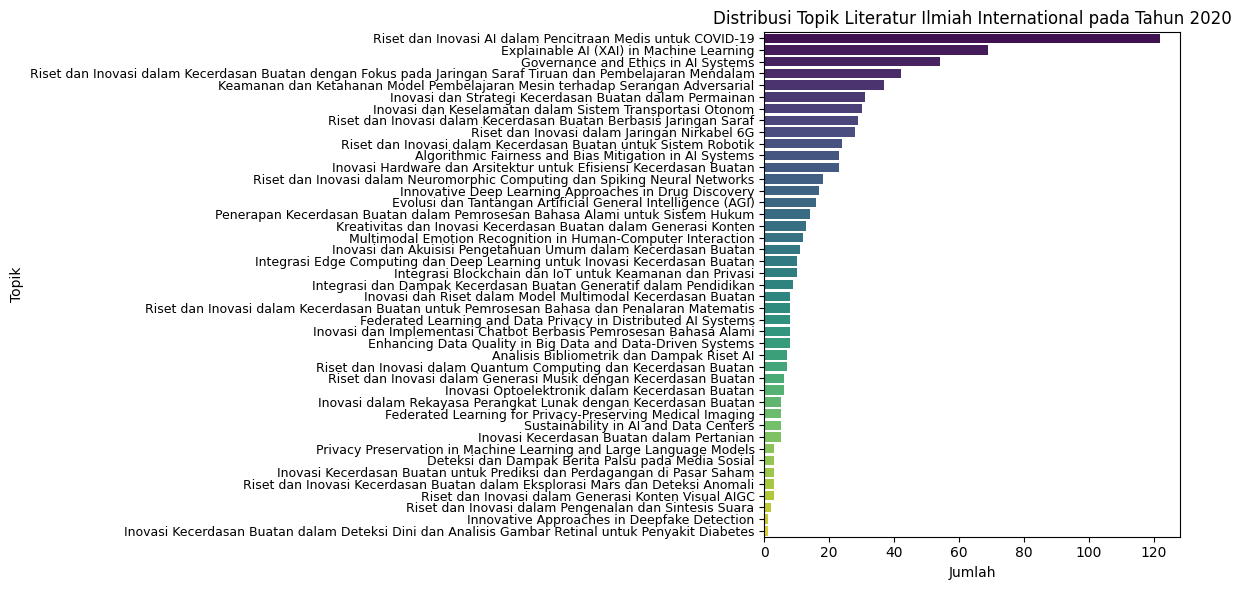

In [42]:
plot_topik_by_tahun(df,2020)

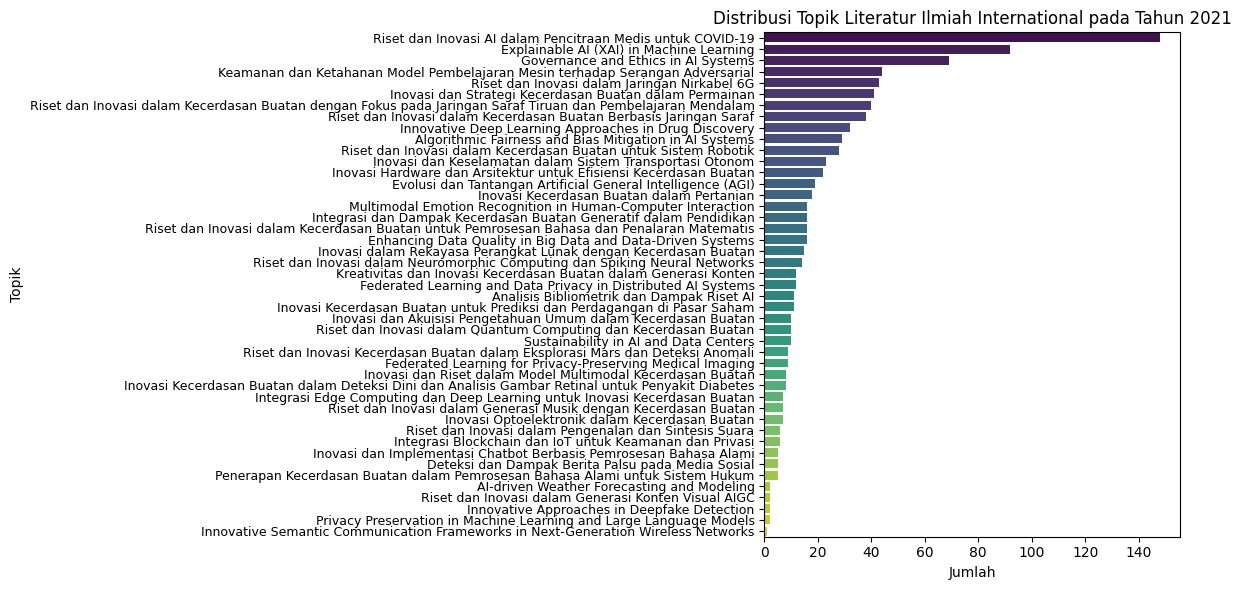

In [43]:
plot_topik_by_tahun(df,2021)

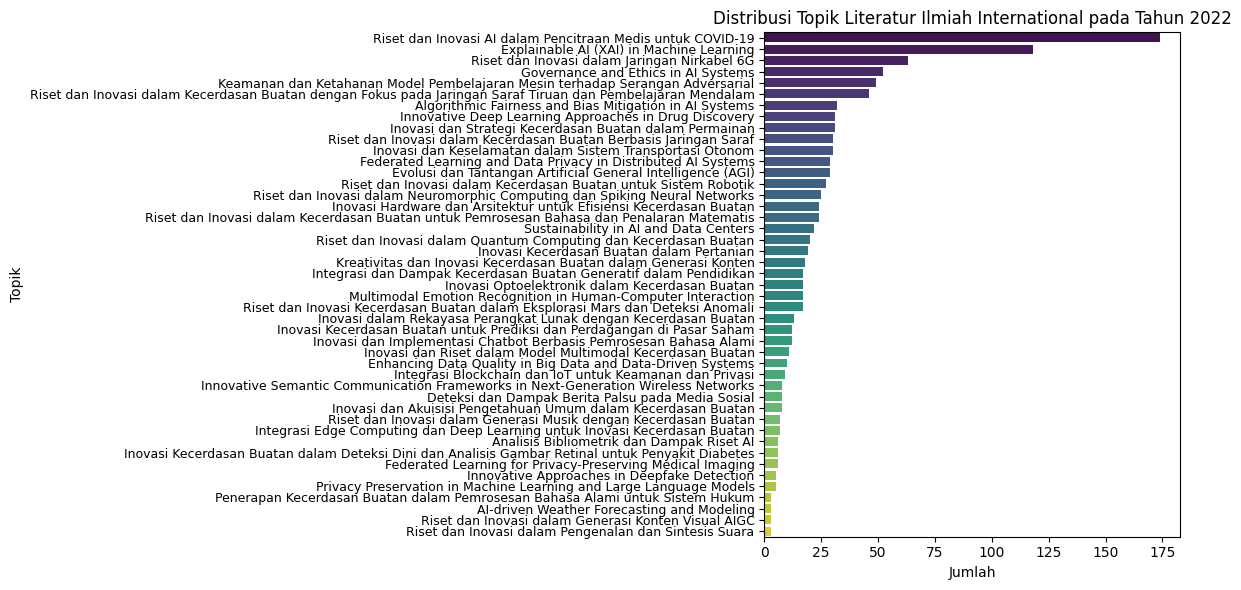

In [44]:
plot_topik_by_tahun(df,2022)

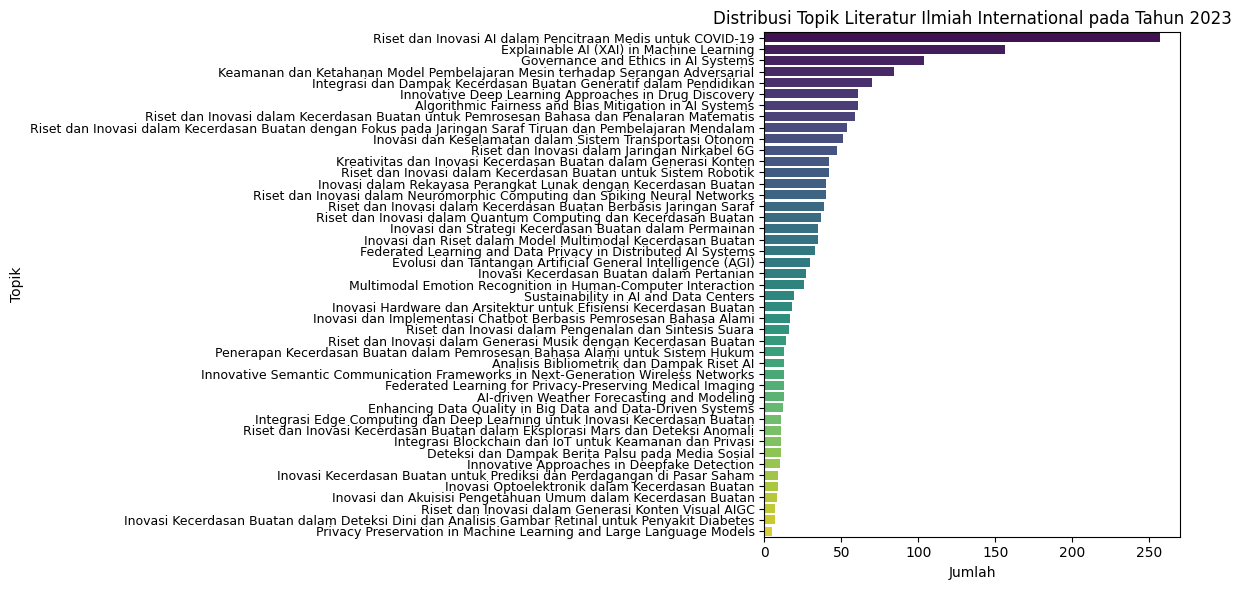

In [45]:
plot_topik_by_tahun(df,2023)

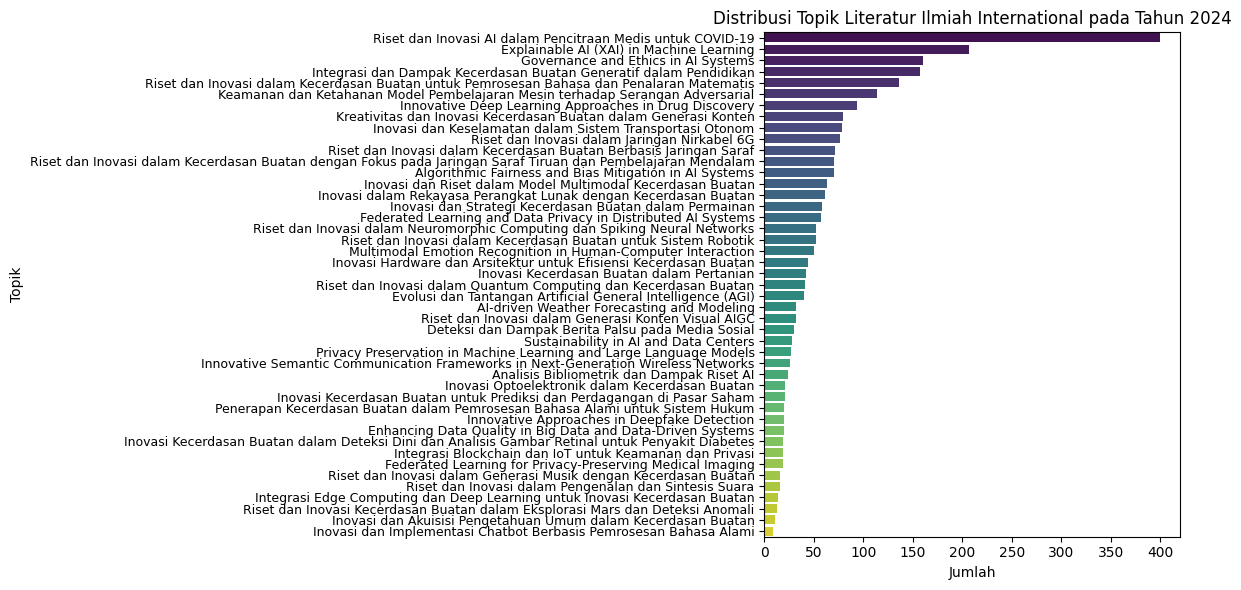

In [46]:
plot_topik_by_tahun(df,2024)

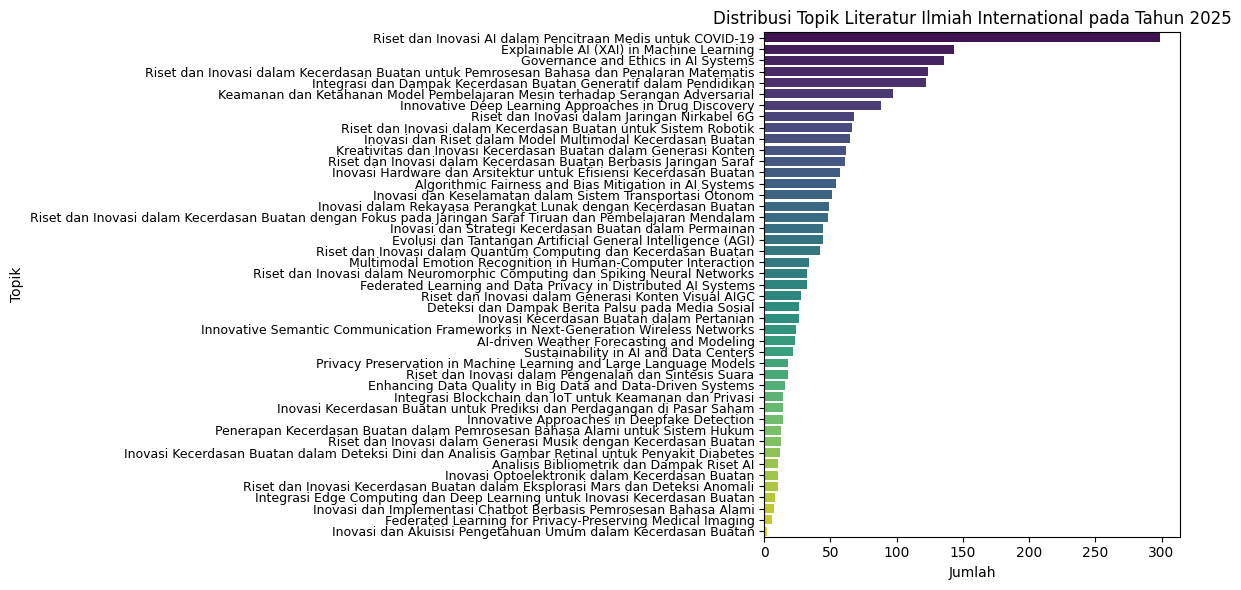

In [47]:
plot_topik_by_tahun(df,2025)

In [107]:
bert_df = pd.DataFrame()
bert_df['topic_id'] = bert_topic_info['Topic']
bert_df['keyword'] = bert_topic_info['KeyBERTInspired']
bert_df['topic_label'] = bert_df['topic_id'].apply(lambda x : bert_sum[str(x)]['label_topik'])
bert_df['topic_desc'] = bert_df['topic_id'].apply(lambda x : bert_sum[str(x)]['deskripsi'])

In [109]:
bert_df.to_csv('Topik Artikel Bahasa Inggris.csv',index=False)

In [112]:
df.to_csv('ENG_articles_labeled.csv',index=False)